# Project 5B: Flow Matching from Scratch!

## Setup environment

In [1]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

/bin/bash: /home/ubuntu/Misty/cv-lax/.k/bin/pip: /lambda/nfs/Misty/k/.k/bin/python: bad interpreter: No such file or directory


In [1]:
# Import essential modules. Feel free to add whatever you need.
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm

## Neural Network Resources

In this part, you will build and train a [UNet](https://arxiv.org/abs/1505.04597), which is more complex than the MLP you implemented in the NeRF project.  We provide all class definitions you may need (but feel free to add or modify them as necessary).  

Instead of asking ChatGPT to write everything for you, please consult the following resources when you get stuck — they will help you understand how and why things work under the hood.

- PyTorch Documentation — [`Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [`ConvTranspose2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), and [`AvgPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html).
- PyTorch Documentation - [`torchvision.datasets.MNIST`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), the dataset we gonna use, and [`torch.utils.data.DataLoader`](https://docs.pytorch.org/docs/stable/data.html), the off-the-shell dataloader we can directly use.
- PyTorch [tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) on how to train a classifier on CIFAR10 dataset. The structure of your training code will be very similar to this one.

# Part 1: Training a Single-step Denoising UNet


# Part 1.1: Implementing the UNet

## Implementing Simple and Composed Ops

In [13]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.net(x)
        # ===== end of code ====
        raise NotImplementedError()


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.net(x)
        # ===== end of code ====
        raise NotImplementedError()


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.net(x)
        # ===== end of code ====
        raise NotImplementedError()


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        # ===== your code here! ====
        self.net = nn.Flatten()
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.net(x)
        # ===== end of code ====
        raise NotImplementedError()


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.in_channels = in_channels
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        n = x.shape[0]
        hw = x.shape[1] // self.in_channels
        h = w = int(hw**0.5)
        assert h * w * self.in_channels == x.shape[1], "Unflatten expects a square spatial size."
        return x.view(n, self.in_channels, h, w)
        # ===== end of code ====
        raise NotImplementedError()


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.net = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels),
        )
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        return self.net(x)
        # ===== end of code ====
        raise NotImplementedError()


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.block = ConvBlock(in_channels, out_channels)
        self.down = DownConv(out_channels, out_channels)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        h = self.block(x)
        x_down = self.down(h)
        return h, x_down  # skip, downsampled
        # ===== end of code ====
        raise NotImplementedError()


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====
        self.up = UpConv(in_channels, out_channels)
        self.block = ConvBlock(out_channels, out_channels)

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====
        x = self.up(x)
        x = self.block(x)
        return x
        # ===== end of code ====
        raise NotImplementedError()

## Implementing Unconditional UNet

In [14]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====
        h = num_hiddens

        self.in_conv = ConvBlock(in_channels, h)

        self.down1 = DownBlock(h, 2 * h)      # 28 -> 14
        self.down2 = DownBlock(2 * h, 4 * h)  # 14 -> 7

        self.mid = ConvBlock(4 * h, 4 * h)

        # up from 7 -> 14
        self.up2 = UpConv(4 * h, 2 * h)
        # concat: up(2h) + skip(4h) = 6h  ✅
        self.up2_block = ConvBlock(6 * h, 2 * h)

        # up from 14 -> 28
        self.up1 = UpConv(2 * h, h)
        # concat: up(h) + skip(2h) = 3h ✅
        self.up1_block = ConvBlock(3 * h, h)
        self.out = nn.Conv2d(h, in_channels, kernel_size=1)
        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====
        x0 = self.in_conv(x)           # (N,h,28,28)

        s1, x1 = self.down1(x0)        # s1: (N,2h,28,28)?? no, block outputs 2h at 28; then down to 14
        s2, x2 = self.down2(x1)        # down to 7

        x_mid = self.mid(x2)

        x = self.up2(x_mid)            # (N,2h,14,14)
        x = torch.cat([x, s2], dim=1)  # concat skip at 14
        x = self.up2_block(x)

        x = self.up1(x)                # (N,h,28,28)
        x = torch.cat([x, s1], dim=1)  # concat skip at 28
        x = self.up1_block(x)

        return self.out(x)
        # ===== end of code ====
        raise NotImplementedError()

# Part 1.2: Using the UNet to Train a Denoiser

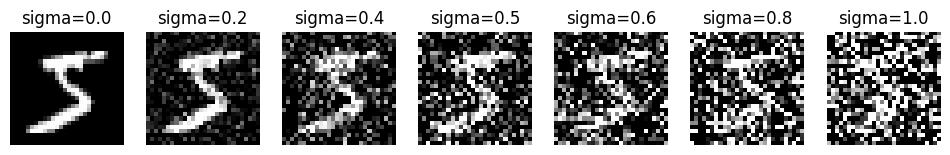

In [23]:
# Visualize images at different noisy level
# ===== your code here! ====
tmp_ds = MNIST(root="./data", train=True, download=True, transform=ToTensor())
x, _ = tmp_ds[0]  # (1,28,28)

sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
fig, axes = plt.subplots(1, len(sigmas), figsize=(12, 3))
for ax, s in zip(axes, sigmas):
    noisy = x + s * torch.randn_like(x)
    ax.imshow(noisy.squeeze(0).clamp(0, 1), cmap="gray")
    ax.set_title(f"sigma={s}")
    ax.axis("off")
plt.show()
# ===== end of code ====

## Part 1.2.1: Training

For this part, we provide some structure code for training. It is very basic, so feel free to change them or add your code. In later section we won't provide any training or visualization structure code.

In [ ]:
device = torch.device('cuda')

# Set your hyperparameters
# ===== your code here! ====
batch_size = 256
learning_rate = 1e-4
noise_level = 0.5
hidden_dim = 128
num_epochs = 5
# ===== end of code ====

In [17]:
# Define your datasets and dataloaders
# ===== your code here! ====
train_dataset = MNIST(root="./data", train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root="./data", train=False, download=True, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
# ===== end of code ====

In [18]:
# Define your model, optimizer, and loss
# ===== your code here! ====
model = UnconditionalUNet(in_channels=1, num_hiddens=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
# ===== end of code ====


 99%|█████████▉| 117/118 [00:17<00:00,  6.74it/s]

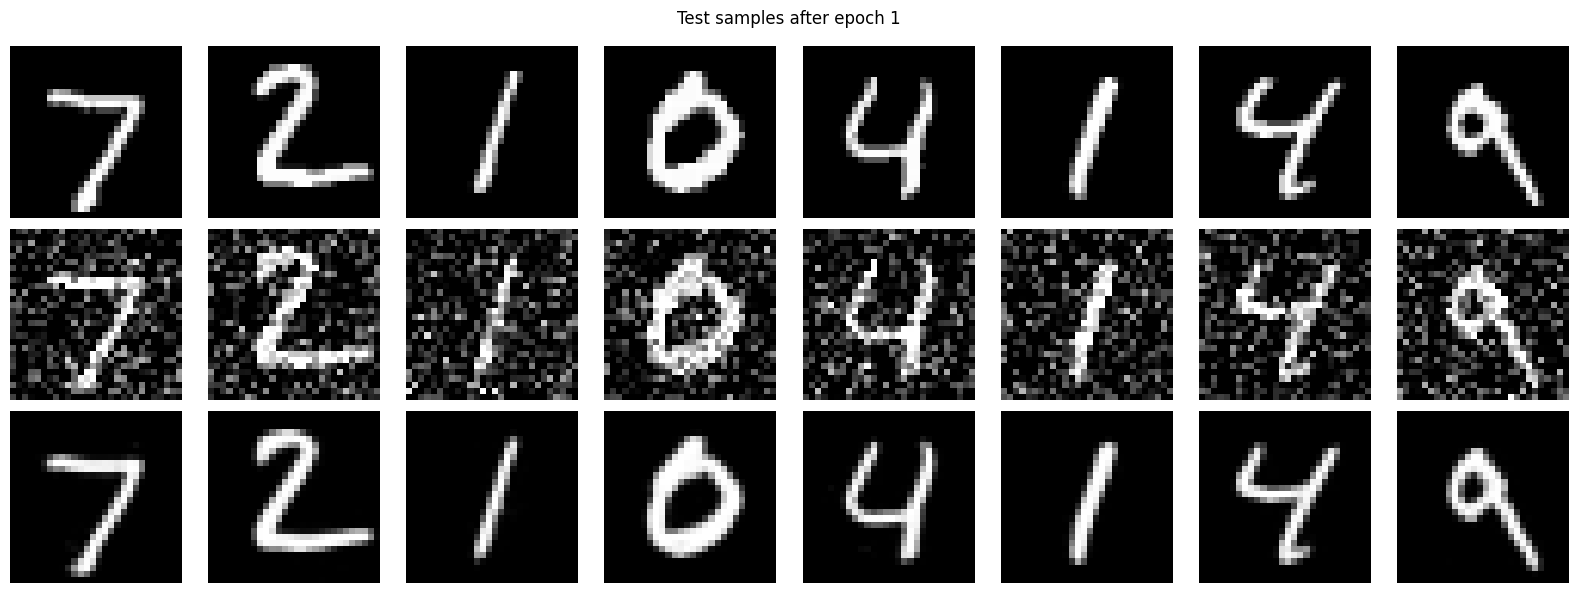

 69%|██████▊   | 81/118 [00:12<00:05,  6.74it/s]

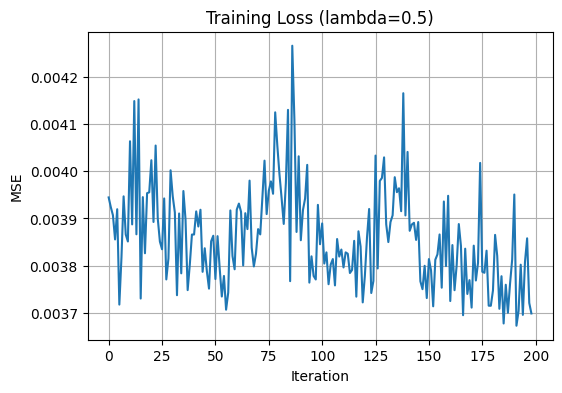

 38%|███▊      | 45/118 [00:06<00:10,  6.73it/s]

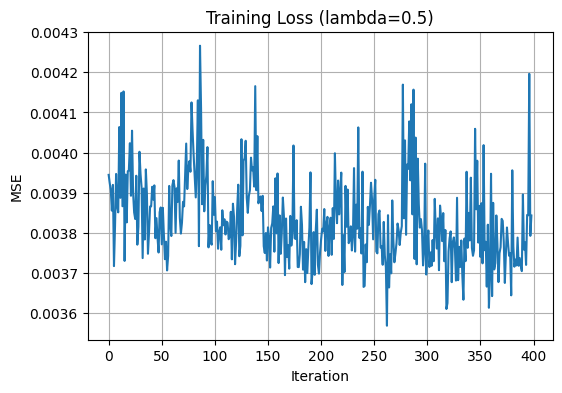

 99%|█████████▉| 117/118 [00:17<00:00,  6.68it/s]

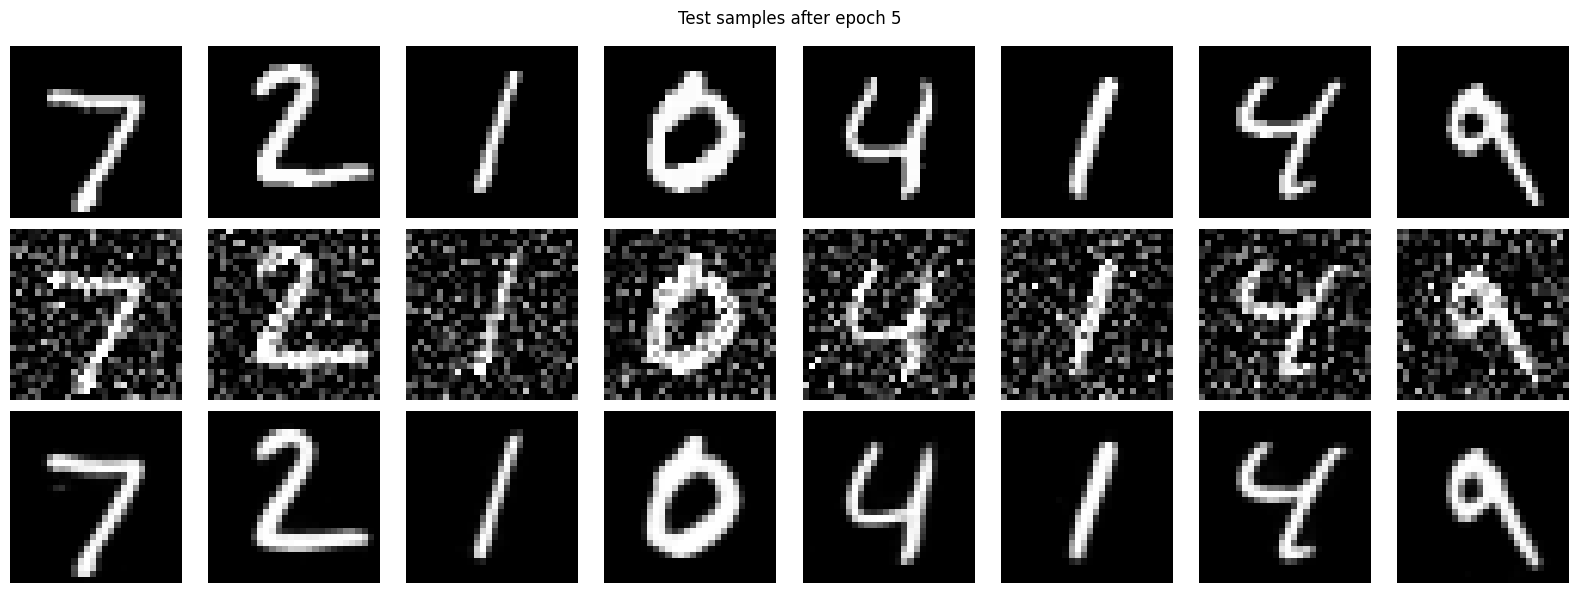

  8%|▊         | 9/118 [00:01<00:16,  6.61it/s]

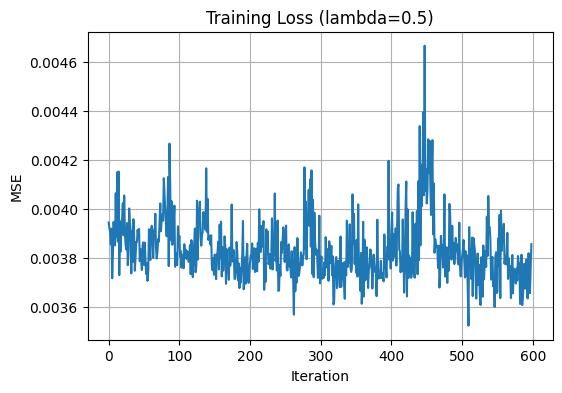

 77%|███████▋  | 91/118 [00:13<00:04,  6.70it/s]

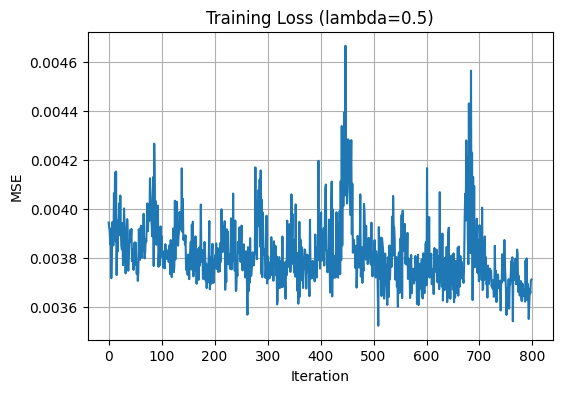

 47%|████▋     | 55/118 [00:08<00:09,  6.73it/s]

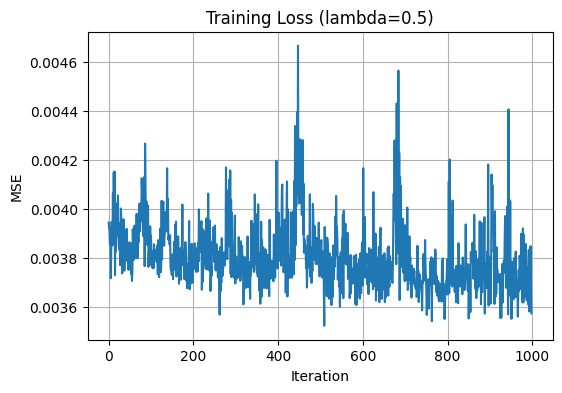

 16%|█▌        | 19/118 [00:02<00:14,  6.71it/s]

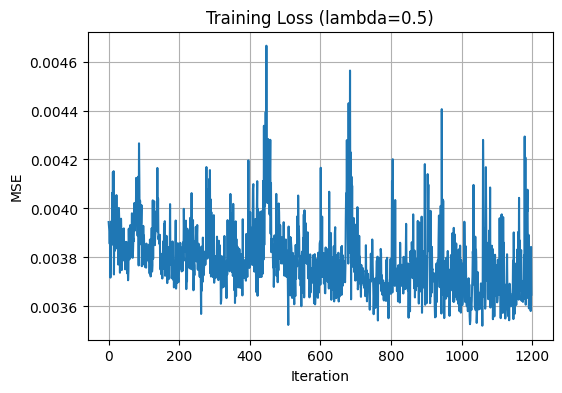

 86%|████████▌ | 101/118 [00:15<00:02,  6.70it/s]

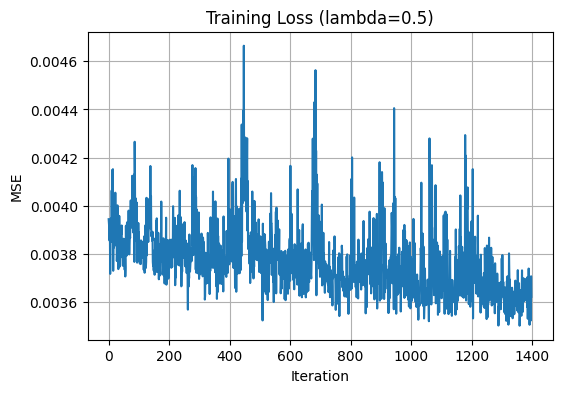

 55%|█████▌    | 65/118 [00:09<00:07,  6.71it/s]

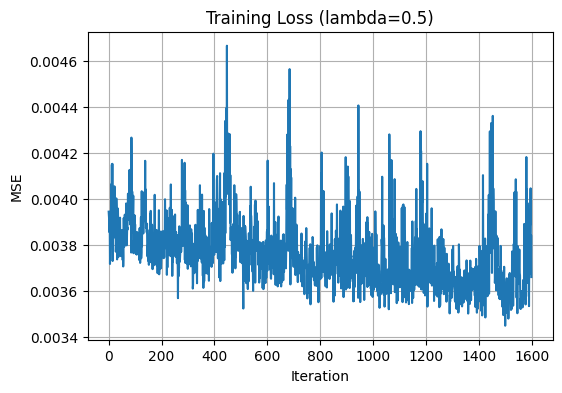

 25%|██▍       | 29/118 [00:04<00:13,  6.71it/s]

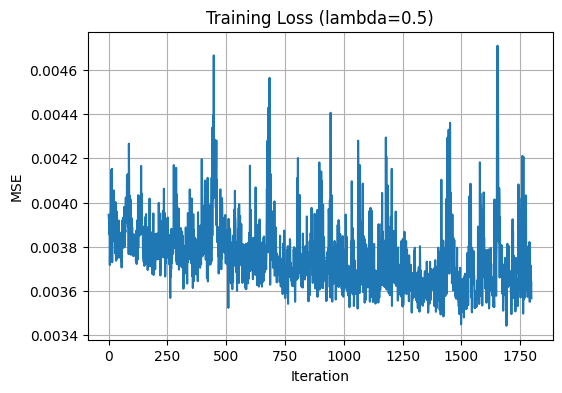

 94%|█████████▍| 111/118 [00:16<00:01,  6.70it/s]

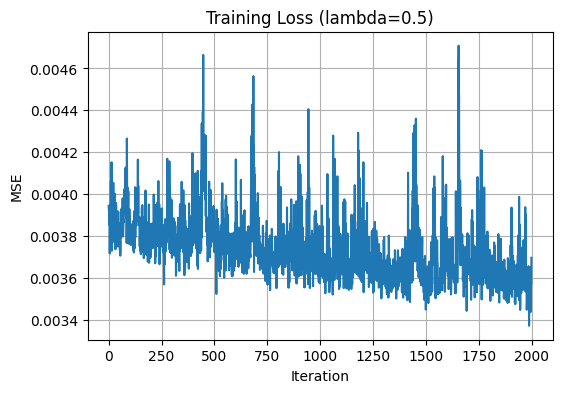

 64%|██████▎   | 75/118 [00:11<00:06,  6.71it/s]

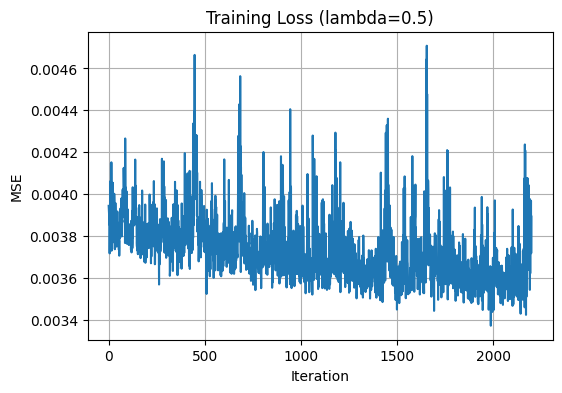

100%|██████████| 118/118 [00:17<00:00,  6.69it/s]


In [21]:
# The training loops
train_losses = []
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):

        # ===== your code here! ====

        images = images.to(device)
        noisy = images + noise_level * torch.randn_like(images)
        outputs = model(noisy)

        # 1) training loss curve plot every few iterations (during whole training)
        plot_every = 200  # you can change this number
        if (len(train_losses) + 1) % plot_every == 0:
            plt.figure(figsize=(6, 4))
            plt.plot(train_losses)
            plt.title("Training Loss (lambda=0.5)")
            plt.xlabel("Iteration")
            plt.ylabel("MSE")
            plt.grid(True)
            plt.show()

        # 2) sample results on test set with noise level 0.5 after 1st and 5th epoch
        # (trigger at the last iteration of epoch 0 and epoch 4)
        if (i == len(train_loader) - 1) and (epoch in [0, 4]):
            model.eval()
            with torch.no_grad():
                test_images, _ = next(iter(test_loader))
                test_images = test_images[:8].to(device)
                test_noisy = test_images + noise_level * torch.randn_like(test_images)
                test_denoised = model(test_noisy)

            clean = test_images.detach().cpu()
            noisy_cpu = test_noisy.detach().cpu()
            den = test_denoised.detach().cpu()

            fig, axes = plt.subplots(3, 8, figsize=(16, 6))
            for j in range(8):
                axes[0, j].imshow(clean[j].squeeze(0).clamp(0, 1), cmap="gray"); axes[0, j].axis("off")
                axes[1, j].imshow(noisy_cpu[j].squeeze(0).clamp(0, 1), cmap="gray"); axes[1, j].axis("off")
                axes[2, j].imshow(den[j].squeeze(0).clamp(0, 1), cmap="gray"); axes[2, j].axis("off")
            axes[0, 0].set_ylabel("clean")
            axes[1, 0].set_ylabel("noisy (λ=0.5)")
            axes[2, 0].set_ylabel("denoised")
            plt.suptitle(f"Test samples after epoch {epoch+1}")
            plt.tight_layout()
            plt.show()
            model.train()
        # ===== end of code ====


        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

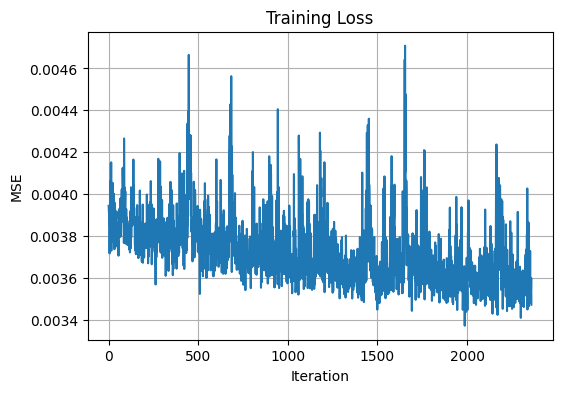

In [22]:
# Visualize your training curve
# ===== your code here! ====
plt.figure(figsize=(6, 4))
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.show()
# ===== end of code ====

## Part 1.2.2: Out-of-Distribution Testing

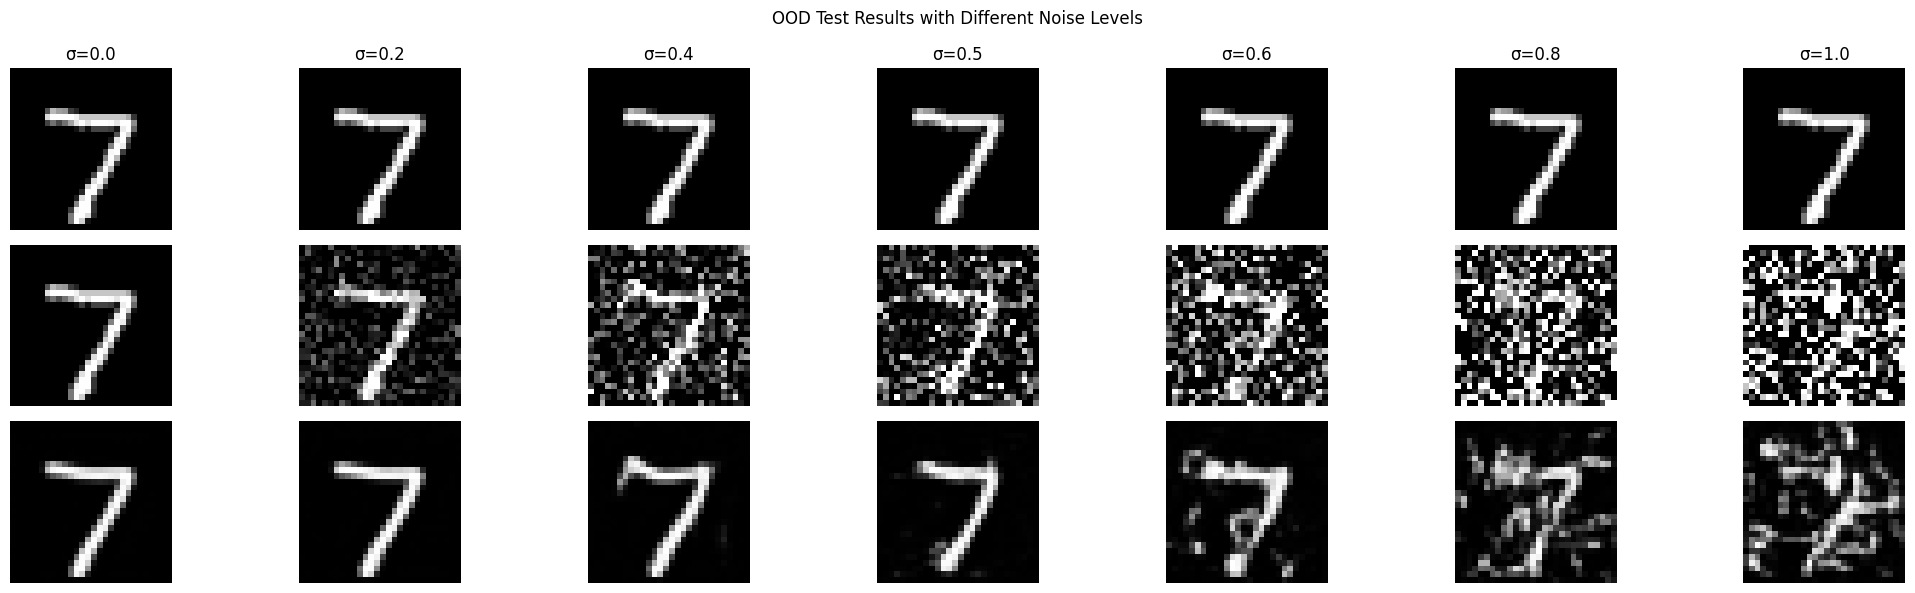

UnconditionalUNet(
  (in_conv): ConvBlock(
    (net): Sequential(
      (0): Conv(
        (net): Sequential(
          (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
      (1): Conv(
        (net): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
    )
  )
  (down1): DownBlock(
    (block): ConvBlock(
      (net): Sequential(
        (0): Conv(
          (net): Sequential(
            (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU()
          )
        )
        (1): Conv(
          (net): Sequential(
    

In [24]:
# Visualize OOD testing
# ===== your code here! ====
model.eval()

noise_levels = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

# keep the same test image
images, _ = next(iter(test_loader))
images = images[:1].to(device)  # one fixed image

clean = images.detach().cpu()

fig, axes = plt.subplots(3, len(noise_levels), figsize=(3 * len(noise_levels), 6))

for idx, nl in enumerate(noise_levels):
    noisy = images + nl * torch.randn_like(images)

    with torch.no_grad():
        denoised = model(noisy)

    noisy_cpu = noisy.detach().cpu()
    den_cpu = denoised.detach().cpu()

    axes[0, idx].imshow(clean[0].squeeze(0), cmap="gray")
    axes[0, idx].set_title(f"σ={nl}")
    axes[0, idx].axis("off")

    axes[1, idx].imshow(noisy_cpu[0].squeeze(0).clamp(0, 1), cmap="gray")
    axes[1, idx].axis("off")

    axes[2, idx].imshow(den_cpu[0].squeeze(0).clamp(0, 1), cmap="gray")
    axes[2, idx].axis("off")

axes[0, 0].set_ylabel("clean")
axes[1, 0].set_ylabel("noisy")
axes[2, 0].set_ylabel("denoised")

plt.suptitle("OOD Test Results with Different Noise Levels")
plt.tight_layout()
plt.show()

model.train()
# ===== end of code ====


## Part 1.2.3 Denoising Pure Noise

In [ ]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====

# ===== end of code ====

# Part 2: Flow Matching

# Part 2.1: Implementing a Time-conditioned UNet

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # ===== your code here! ====

        # ===== end of code ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ===== your code here! ====

        # ===== end of code ====
        raise NotImplementedError()


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====

        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====

        # ===== end of code ====
        raise NotImplementedError()

## Implementing the Forward and Reverse Process for Time-conditioned Denoising

In [ ]:
def time_fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """
    unet.train()
    # ===== your code here! ====

    # ===== end of code ====
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def time_fm_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # ===== your code here! ====

    # ===== end of code ====
    raise NotImplementedError()

In [ ]:
class TimeConditionalFM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return time_fm_forward(
            self.unet, x, self.num_ts
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return time_fm_sample(
            self.unet, img_wh, self.num_ts, seed
        )


# Part 2.2: Training the Time-conditioned UNet

In [ ]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====

# ===== end of code ====

# Part 2.3: Sampling from the Time-conditioned UNet

In [ ]:
# Sampling from the UNet
# ===== your code here! ====

# ===== end of code ====

# Part 2.4: Implementing a Class-conditioned UNet

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        # ===== your code here! ====

        # ===== end of code ====

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # ===== your code here! ====

        # ===== end of code ====
        raise NotImplementedError()

In [ ]:
def class_fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) loss.
    """
    unet.train()
    # ===== your code here! ====

    # ===== end of code ====
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def class_fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4

    Args:
        unet: ClassConditionalUNet
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # ===== your code here! ====

    # ===== end of code ====
    raise NotImplementedError()

In [ ]:
class ClassConditionalFM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return class_fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return class_fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )

# Part 2.5 Training the Class-conditioned UNet

In [ ]:
# Feel free to use code from part 1.2.1
# as they should be very similar
# ===== your code here! ====

# ===== end of code ====

# Part 2.6: Sampling from the Class-conditioned UNet

In [ ]:
# Sampling from the UNet
# ===== your code here! ====

# ===== end of code ====